In [49]:
import numpy as np
import pandas as pd
import re

### 1. clean data

In [50]:
# read data
data = pd.read_csv("Data.csv", encoding='latin1')


#### 1-1 writing format

In [51]:
# deal with column names

## delete space
data.columns = data.columns.str.strip()
## replace special characters with "_"
data.columns = (
    data.columns
      .str.lower()  # 转小写
      .str.replace(r"[^a-z0-9 _]", " ", regex=True)  # 保留小写字母、数字、空格、_
      .str.replace(r"\s+", "_", regex=True)  # 多空格变_
      .str.strip("_")  # 去除开头结尾的_
)

data.columns


Index(['contact_id', 'intake_details_submission_date',
       'type_of_assistance_applied', 'care_team', 'gender', 'age', 'race',
       'occupation', 'housing_type', 'home_ownership',
       'monthly_mortgage_cpf_cash', 'monthly_rental', 'identity_id_type',
       'intake_no_of_hh', 'intake_pci', 'intake_status',
       'reason_for_rejection_or_cancelled', 'income_assessment_salary',
       'income_assessment_cpf_payout',
       'income_assessment_assistance_from_other_agencies',
       'income_assessment_assistance_from_relatives_friends',
       'income_assessment_insurance_payout', 'income_assessment_rental_income',
       'income_assessment_others_income', 'income_assessment_total_income',
       'expenditure_assessment_mortgage_rental',
       'expenditure_assessmen_utilities', 'expenditure_assessment_s_cc_fees',
       'expenditure_assessment_food_expenses',
       'expenditure_assessment_marketing_groceries',
       'expenditure_assessment_telecommunications',
       'expenditu

In [52]:
# deal with column (type: date)
data['intake_details_submission_date'] = pd.to_datetime(
    data['intake_details_submission_date'], errors='coerce'
)
data['assessment_date_time'] = pd.to_datetime(
    data['assessment_date_time'], errors='coerce'
)

data['intake_details_submission_date'] = data['intake_details_submission_date'].dt.date
data['assessment_date_time'] = data['assessment_date_time'].dt.date


In [53]:
data.dtypes

contact_id                                                int64
intake_details_submission_date                           object
type_of_assistance_applied                               object
care_team                                                object
gender                                                   object
age                                                     float64
race                                                     object
occupation                                               object
housing_type                                             object
home_ownership                                           object
monthly_mortgage_cpf_cash                                object
monthly_rental                                           object
identity_id_type                                         object
intake_no_of_hh                                         float64
intake_pci                                              float64
intake_status                           

In [54]:
# delete special characters in columns (type: object)
def clean_text(text):
    if isinstance(text, str):
        # 移除非字母或数字的字符
        text = text.replace("?","")
        # 转为小写
        text = text.lower()
    return text

for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].apply(clean_text)

In [55]:
# delete special characters in columns (type: numeric)
def clean_dollar(text):
    if isinstance(text, str):
        text = text.replace("(","-")
        # 使用正则表达式保留数字、小数点和负号
        text = re.sub(r"[^\d.-]", "", text)
        
        # 检查结果是否是一个有效的数字
        # 如果结果是一个单独的负号或空字符串，则返回空字符串
        if text in ["", "-"]:
            return ""
        
        # 确保负号只出现在开头
        if text.count('-') > 1 or (text.count('-') == 1 and text[0] != '-'):
            return ""
        
    return text


dollar_cols = [
    "assistance_amount",
    "copayment",
    "monthly_rental",
    "i_e_difference_self_declaration",
    "i_e_difference_assessment",
    "invoice_amount",
]

for col in dollar_cols:
    data[col] = data[col].apply(clean_dollar)
    data[col] = pd.to_numeric(data[col])

In [56]:
# "occupation"
# 仅保留'unemployed','retired','part-time','student'四种
occupation = {
    "unemployed": [
        "unfit for work",
        "unemployed",
        "unemployed unfit for work",
        "unemployedunfit for work",
        "unemployedmedically unfit to work",
        "unemployed (medically unfit for work)",
        "unemployed (paraplegic since 2005 accident)",
        "unemployedmedically unfit for work",
        "unempolyed",
        "not employed",
        "not working",
        "nil",
        "unemployed (due to medical conditions)",
        "unemployed/ can collector",
        "unfit for work",
        "not sure",
        "uneployed",
        "unempployed",
        "unemployed due to medical reasons",
        "unemployed (unfit for work)",
        "unemployed (unfit for work)",
        "unemployed (elderly)",
        "unemployed (medically unfit)",
        "unfit to work",
        "unfit for employment",
        "n.a.",
        "unemployed- permantly unfit for work",
        "unemployed due to medical conditions",
        "not been employed for the past 7 years",
    ],
    "retired": [
        "retired",
        "retiree",
        "tetiree",
        "reitree",
        "retired",
        "retired cleaner",
        "na - retiree",
        "retired cleaner",
        "retiree",
    ],
    "part-time": [
        "part timer",
        "part-time actor",
        "part time baker",
        "part time f&b",
        "part-time tutor",
        "part-time lala move driver",
        "part-timer",
        "part-time admin",
        "part-time service crew",
        "part-time security officer",
        "part time macdonald",
        "part time security",
        "part-time cashier",
        "part-time shop assistant",
        "part-time security guard",
        "part-time cleaner",
        "part-time stall assistant",
        "part-time",
        "part-time photo developer",
        "part time kitchen helper",
        "part-timer art teacher",
    ],
    "student": ["student", "nus y2 student"],
}


employed_set = set()


def unify_occupation(text):
    global employed_set
    if pd.isna(text) or text.strip() == "":
        return "NA"
    find = False
    # print(text)
    text = text.strip()
    ans = ""
    for i in occupation:
        if text in occupation[i]:
            find = True
            ans = i
            break

    if find:
        return ans
    else:
        employed_set.add(text)
        return "employed"


data["occupation"] = data["occupation"].apply(unify_occupation)

occupation_counts = data["occupation"].value_counts()

print(occupation_counts)


occupation
unemployed    799
employed      258
retired       230
NA            101
student        34
part-time      24
Name: count, dtype: int64


In [57]:
data = data.rename(columns={'expenditure_assessmen_utilities': 'expenditure_assessment_utilities'})
data = data.rename(columns={'expenditure_assessmen_medical_expenses': 'expenditure_assessment_medical_expenses'})
data = data.rename(columns={'expenditure_assessmen_contribution_to_family_members': 'expenditure_assessment_contribution_to_family_members'})


#### 1-2 drop columns

In [58]:
# drop columns which cannot be used
drop_cols_1=[
    "contact_id",
    "intake_details_submission_date",
    "reason_for_rejection_or_cancelled",
    "assistance_details",
    "remarks_no_of_hh"
]

# drop duplicates
# application v.s. assessment (delete application)
drop_cols_2=[
    "monthly_mortgage_cpf_cash",
    'monthly_rental',
    'intake_pci'
]

# drop columns to be fair
# -- ‘Nationality', 'ID type', 'Gender', 'Race', 'type of assistant applied', 'Housing Type', 'Home Ownership'

drop_cols_3=[
    'identity_id_type',
    'gender', 
    'race', 
    'housing_type', 
    'home_ownership'
]


drop_cols = drop_cols_1 + drop_cols_2 + drop_cols_3
data = data.drop(columns=drop_cols)


In [11]:
data

,type_of_assistance_applied,care_team,age,occupation,intake_no_of_hh,intake_status,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,...,invoice_amount,copayment,case_profile,no_of_hh,before_primary,primary_7_12,secondary_13_17,tertiary_18_21,adult_22_64,elderly_65_and_above
0,education fees assistance,central 1 1,13.0,student,3.0,confirm,0.0,0.0,500.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,interim dialysis assistance,central 1 1,57.0,unemployed,2.0,confirm,1500.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,medical consumables assistance,central 1 1,32.0,unemployed,4.0,confirm,3380.0,0.0,0.0,500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,household living assistance,central 1 1,69.0,NA,2.0,confirm,525.0,0.0,200.0,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,household living assistance,central 1 1,70.0,NA,1.0,confirm,134.0,0.0,90.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,education fees assistance,south 1 1,14.0,student,NaN,NaN,2400.0,0.0,240.0,0.0,...,NaN,NaN,"single parent , schooling children",3.0,NaN,NaN,1.0,NaN,1.0,1.0
1442,household living assistance,central 1 1,37.0,part-time,NaN,NaN,875.0,0.0,1080.0,0.0,...,NaN,NaN,"renal patient , schooling children , disabilit...",4.0,1.0,1.0,NaN,NaN,2.0,NaN
1443,education fees assistance,south 3 3,19.0,student,NaN,NaN,950.0,0.0,2500.6,400.0,...,NaN,NaN,schooling children,7.0,1.0,1.0,NaN,2.0,3.0,NaN
1444,medical transport assistance,east 4 4,67.0,retired,NaN,NaN,NaN,NaN,NaN,NaN,...,2080.0,NaN,"living alone elderly , renal patient",1.0,NaN,NaN,NaN,NaN,NaN,1.0


In [12]:
data.columns

Index(['type_of_assistance_applied', 'care_team', 'age', 'occupation',
       'intake_no_of_hh', 'intake_status', 'income_assessment_salary',
       'income_assessment_cpf_payout',
       'income_assessment_assistance_from_other_agencies',
       'income_assessment_assistance_from_relatives_friends',
       'income_assessment_insurance_payout', 'income_assessment_rental_income',
       'income_assessment_others_income', 'income_assessment_total_income',
       'expenditure_assessment_mortgage_rental',
       'expenditure_assessment_utilities', 'expenditure_assessment_s_cc_fees',
       'expenditure_assessment_food_expenses',
       'expenditure_assessment_marketing_groceries',
       'expenditure_assessment_telecommunications',
       'expenditure_assessment_transportation',
       'expenditure_assessment_medical_expenses',
       'expenditure_assessment_education_expense',
       'expenditure_assessment_contribution_to_family_members',
       'expenditure_assessment_domestic_helper',


#### 1-3 check calculation results in raw data with code
#### -- delete manually calculation results （‘Income Assessment: Total Income’， 'Expenditure Assessment: Total Expenditure'， 'I&E Difference (self-declaration)', 'I&E Difference (assessment)'）

In [59]:
# fill blank record and NAN with 0
def fill_0(text):
    if isinstance(text, str) and text.strip() == "":
        return 0
    return text


data = data.apply(fill_0)  # 先处理空白填0
data = data.fillna(0)  # 万一有非法的NaN也一起补成0
data


,type_of_assistance_applied,care_team,age,occupation,intake_no_of_hh,intake_status,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,...,invoice_amount,copayment,case_profile,no_of_hh,before_primary,primary_7_12,secondary_13_17,tertiary_18_21,adult_22_64,elderly_65_and_above
0,education fees assistance,central 1 1,13.0,student,3.0,confirm,0.0,0.0,500.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,interim dialysis assistance,central 1 1,57.0,unemployed,2.0,confirm,1500.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,medical consumables assistance,central 1 1,32.0,unemployed,4.0,confirm,3380.0,0.0,0.0,500.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,household living assistance,central 1 1,69.0,NA,2.0,confirm,525.0,0.0,200.0,400.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,household living assistance,central 1 1,70.0,NA,1.0,confirm,134.0,0.0,90.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,education fees assistance,south 1 1,14.0,student,0.0,0,2400.0,0.0,240.0,0.0,...,0.0,0.0,"single parent , schooling children",3.0,0.0,0.0,1.0,0.0,1.0,1.0
1442,household living assistance,central 1 1,37.0,part-time,0.0,0,875.0,0.0,1080.0,0.0,...,0.0,0.0,"renal patient , schooling children , disabilit...",4.0,1.0,1.0,0.0,0.0,2.0,0.0
1443,education fees assistance,south 3 3,19.0,student,0.0,0,950.0,0.0,2500.6,400.0,...,0.0,0.0,schooling children,7.0,1.0,1.0,0.0,2.0,3.0,0.0
1444,medical transport assistance,east 4 4,67.0,retired,0.0,0,0.0,0.0,0.0,0.0,...,2080.0,0.0,"living alone elderly , renal patient",1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [60]:
data['no_of_hh_cal'] = data['before_primary'] + data['primary_7_12'] + data['secondary_13_17'] + data['tertiary_18_21'] + data['adult_22_64'] + data['elderly_65_and_above']
data['diff_hh'] = data['no_of_hh_cal']- data['no_of_hh']
data['diff_hh'].isnull().sum()

0

In [61]:
data['income_total_cal'] = data['income_assessment_salary'] + data['income_assessment_cpf_payout'] + data['income_assessment_assistance_from_other_agencies'] + data['income_assessment_assistance_from_relatives_friends'] + data['income_assessment_insurance_payout'] + data['income_assessment_rental_income'] + data['income_assessment_others_income']
data['expenditure_total_cal'] = data['expenditure_assessment_mortgage_rental'] + data['expenditure_assessment_utilities'] + data['expenditure_assessment_s_cc_fees'] + data['expenditure_assessment_food_expenses'] + data['expenditure_assessment_marketing_groceries'] + data['expenditure_assessment_telecommunications'] + data['expenditure_assessment_transportation'] + data['expenditure_assessment_medical_expenses'] + data['expenditure_assessment_education_expense'] + data['expenditure_assessment_contribution_to_family_members'] + data['expenditure_assessment_domestic_helper'] + data['expenditure_assessment_loans_debts_installments'] + data['expenditure_assessment_insurance_premiums'] + data['expenditure_assessment_others_expenditure']
data['difference_cal'] = data['income_total_cal'] - data['expenditure_total_cal']
data


,type_of_assistance_applied,care_team,age,occupation,intake_no_of_hh,intake_status,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,...,primary_7_12,secondary_13_17,tertiary_18_21,adult_22_64,elderly_65_and_above,no_of_hh_cal,diff_hh,income_total_cal,expenditure_total_cal,difference_cal
0,education fees assistance,central 1 1,13.0,student,3.0,confirm,0.0,0.0,500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,1601.90,-1101.90
1,interim dialysis assistance,central 1 1,57.0,unemployed,2.0,confirm,1500.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1084.00,416.00
2,medical consumables assistance,central 1 1,32.0,unemployed,4.0,confirm,3380.0,0.0,0.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3880.0,3494.00,386.00
3,household living assistance,central 1 1,69.0,NA,2.0,confirm,525.0,0.0,200.0,400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1125.0,1114.00,11.00
4,household living assistance,central 1 1,70.0,NA,1.0,confirm,134.0,0.0,90.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474.0,700.00,-226.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,education fees assistance,south 1 1,14.0,student,0.0,0,2400.0,0.0,240.0,0.0,...,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2640.0,2701.25,-61.25
1442,household living assistance,central 1 1,37.0,part-time,0.0,0,875.0,0.0,1080.0,0.0,...,1.0,0.0,0.0,2.0,0.0,4.0,0.0,1955.0,1904.60,50.40
1443,education fees assistance,south 3 3,19.0,student,0.0,0,950.0,0.0,2500.6,400.0,...,1.0,0.0,2.0,3.0,0.0,7.0,0.0,3850.6,2418.60,1432.00
1444,medical transport assistance,east 4 4,67.0,retired,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,0.00


In [62]:
data['income_total_check'] = data['income_total_cal'] - data['income_assessment_total_income']
data['expenditure_total_check'] = data['expenditure_total_cal'] - data['expenditure_assessment_total_expenditure']
data['difference_check'] = data['i_e_difference_assessment'] - data['difference_cal']
income_nonzero_indices = data.index[data["income_total_check"] != 0].tolist()
expenditure_nonzero_indices = data.index[data["expenditure_total_check"] != 0].tolist()
difference_nonzero_indices = data.index[data["difference_check"] != 0].tolist()

print(len(income_nonzero_indices))
print(len(expenditure_nonzero_indices))
print(len(difference_nonzero_indices))
# 原本手动计算有错误，所以删除手动计算的列，替换为code计算结果

84
241
584


##### check what's wrong with previous calculation

In [63]:
data['difference_check'].sum()

132616.53999999998

In [64]:
check_indices = data.index[data["difference_check"] == data['difference_check'].max()].tolist()
check_indices

[1094]

In [65]:
data.loc[check_indices]

,type_of_assistance_applied,care_team,age,occupation,intake_no_of_hh,intake_status,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,...,adult_22_64,elderly_65_and_above,no_of_hh_cal,diff_hh,income_total_cal,expenditure_total_cal,difference_cal,income_total_check,expenditure_total_check,difference_check
1094,medical consumables assistance,central 1 1,51.0,unemployed,5.0,confirm,0.0,0.0,1837.0,0.0,...,4.0,1.0,5.0,0.0,1837.0,7601.4,-5764.4,0.0,300.0,11228.8


##### drop columns in process

In [66]:
drop_cols=[
'income_assessment_total_income',
'expenditure_assessment_total_expenditure',
'i_e_difference_self_declaration', 
'i_e_difference_assessment',
'income_total_check',
'expenditure_total_check',
'difference_check'
]

data = data.drop(columns=drop_cols)
print(data.columns)

Index(['type_of_assistance_applied', 'care_team', 'age', 'occupation',
       'intake_no_of_hh', 'intake_status', 'income_assessment_salary',
       'income_assessment_cpf_payout',
       'income_assessment_assistance_from_other_agencies',
       'income_assessment_assistance_from_relatives_friends',
       'income_assessment_insurance_payout', 'income_assessment_rental_income',
       'income_assessment_others_income',
       'expenditure_assessment_mortgage_rental',
       'expenditure_assessment_utilities', 'expenditure_assessment_s_cc_fees',
       'expenditure_assessment_food_expenses',
       'expenditure_assessment_marketing_groceries',
       'expenditure_assessment_telecommunications',
       'expenditure_assessment_transportation',
       'expenditure_assessment_medical_expenses',
       'expenditure_assessment_education_expense',
       'expenditure_assessment_contribution_to_family_members',
       'expenditure_assessment_domestic_helper',
       'expenditure_assessment_loa

In [67]:
data

,type_of_assistance_applied,care_team,age,occupation,intake_no_of_hh,intake_status,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,...,primary_7_12,secondary_13_17,tertiary_18_21,adult_22_64,elderly_65_and_above,no_of_hh_cal,diff_hh,income_total_cal,expenditure_total_cal,difference_cal
0,education fees assistance,central 1 1,13.0,student,3.0,confirm,0.0,0.0,500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,1601.90,-1101.90
1,interim dialysis assistance,central 1 1,57.0,unemployed,2.0,confirm,1500.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1084.00,416.00
2,medical consumables assistance,central 1 1,32.0,unemployed,4.0,confirm,3380.0,0.0,0.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3880.0,3494.00,386.00
3,household living assistance,central 1 1,69.0,NA,2.0,confirm,525.0,0.0,200.0,400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1125.0,1114.00,11.00
4,household living assistance,central 1 1,70.0,NA,1.0,confirm,134.0,0.0,90.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474.0,700.00,-226.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,education fees assistance,south 1 1,14.0,student,0.0,0,2400.0,0.0,240.0,0.0,...,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2640.0,2701.25,-61.25
1442,household living assistance,central 1 1,37.0,part-time,0.0,0,875.0,0.0,1080.0,0.0,...,1.0,0.0,0.0,2.0,0.0,4.0,0.0,1955.0,1904.60,50.40
1443,education fees assistance,south 3 3,19.0,student,0.0,0,950.0,0.0,2500.6,400.0,...,1.0,0.0,2.0,3.0,0.0,7.0,0.0,3850.6,2418.60,1432.00
1444,medical transport assistance,east 4 4,67.0,retired,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,0.00


#### 1-4 assign assistance type columns to foundation standard
#### -- application v.s. assessment (delete application)

In [68]:
# household living assistance
# HIV medication assistance
# interim dialysis assistance 透析（仅提供3个月资助）
# day care fees assistance
# medical transport assistance 提供1年的交通费
# antenatal check fees 产检
# medical consumables assistance 医疗耗材
# education fees assistance
# HCV medication fees assistance 丙肝（一次性药物费用）
# others


In [69]:
# fill type_of_assistances with type_of_assistance_applied record  if any blank
data.loc[data["type_of_assistances"] == 0, "type_of_assistances"] = data.loc[data["type_of_assistances"] == 0, "type_of_assistance_applied"]

data["type_of_assistances"] = data["type_of_assistances"].apply(lambda x:x.split(",")[0].strip())

data["type_of_assistances"] = (
    data["type_of_assistances"]
      .str.lower()  # 转小写
      .str.replace(r"[^a-z _]", " ", regex=True)  # 保留小写字母、空格、_
      .str.replace(r"\s+", "_", regex=True)  # 多空格变_
      .str.strip("_")  # 去除开头结尾的_
)

assistance_counts = data['type_of_assistances'].value_counts()

print(assistance_counts)

type_of_assistances
interim_dialysis_assistance        578
medical_consumables_assistance     340
medical_transport_assistance       209
household_living_assistance        198
education_fees_assistance           32
hiv_medication_fees                 31
day_care_fees_assistance            19
befriending_service                 17
antenatal_check_fees_assistance     11
one_time_assistance                  7
others                               4
Name: count, dtype: int64


In [70]:
data.loc[data["type_of_assistances"].isin(["befriending_service", "one_time_assistance"]), "type_of_assistances"] = "others"
assistance_counts = data['type_of_assistances'].value_counts()

print(assistance_counts)

type_of_assistances
interim_dialysis_assistance        578
medical_consumables_assistance     340
medical_transport_assistance       209
household_living_assistance        198
education_fees_assistance           32
hiv_medication_fees                 31
others                              28
day_care_fees_assistance            19
antenatal_check_fees_assistance     11
Name: count, dtype: int64


In [71]:
# drop type_of_assistance_applied
data = data.drop(columns='type_of_assistance_applied')
data

,care_team,age,occupation,intake_no_of_hh,intake_status,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,income_assessment_insurance_payout,...,primary_7_12,secondary_13_17,tertiary_18_21,adult_22_64,elderly_65_and_above,no_of_hh_cal,diff_hh,income_total_cal,expenditure_total_cal,difference_cal
0,central 1 1,13.0,student,3.0,confirm,0.0,0.0,500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,1601.90,-1101.90
1,central 1 1,57.0,unemployed,2.0,confirm,1500.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1084.00,416.00
2,central 1 1,32.0,unemployed,4.0,confirm,3380.0,0.0,0.0,500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3880.0,3494.00,386.00
3,central 1 1,69.0,NA,2.0,confirm,525.0,0.0,200.0,400.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1125.0,1114.00,11.00
4,central 1 1,70.0,NA,1.0,confirm,134.0,0.0,90.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474.0,700.00,-226.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,south 1 1,14.0,student,0.0,0,2400.0,0.0,240.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2640.0,2701.25,-61.25
1442,central 1 1,37.0,part-time,0.0,0,875.0,0.0,1080.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,4.0,0.0,1955.0,1904.60,50.40
1443,south 3 3,19.0,student,0.0,0,950.0,0.0,2500.6,400.0,0.0,...,1.0,0.0,2.0,3.0,0.0,7.0,0.0,3850.6,2418.60,1432.00
1444,east 4 4,67.0,retired,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,0.00


#### 1-5 delete records

In [72]:
# delete records, in which “Intake_Status” is not “confirm”
data2 = data.copy()
data2 = data2[data2['intake_status'] == "confirm"]
# delete records, in which "Recommendation" is "rejected"
data2 = data2[data2['recommendation'].str.strip() != "rejected"]
#drop "intake_status""recommendation"

drop_cols=[
    "intake_status",
    "recommendation"
]

data2 = data2.drop(columns=drop_cols)

data2

,care_team,age,occupation,intake_no_of_hh,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,income_assessment_insurance_payout,income_assessment_rental_income,...,primary_7_12,secondary_13_17,tertiary_18_21,adult_22_64,elderly_65_and_above,no_of_hh_cal,diff_hh,income_total_cal,expenditure_total_cal,difference_cal
0,central 1 1,13.0,student,3.0,0.0,0.00,500.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.00,1601.9,-1101.90
1,central 1 1,57.0,unemployed,2.0,1500.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.00,1084.0,416.00
2,central 1 1,32.0,unemployed,4.0,3380.0,0.00,0.0,500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3880.00,3494.0,386.00
3,central 1 1,69.0,NA,2.0,525.0,0.00,200.0,400.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1125.00,1114.0,11.00
4,central 1 1,70.0,NA,1.0,134.0,0.00,90.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474.00,700.0,-226.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,south 1 1,55.0,unemployed,4.0,0.0,0.00,1780.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,3.0,0.0,1780.00,1730.0,50.00
1321,east 1 1,55.0,employed,1.0,0.0,0.00,600.0,150.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,750.00,2285.0,-1535.00
1326,south 2 2,62.0,unemployed,3.0,0.0,0.00,1080.0,0.0,0.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1580.00,1530.0,50.00
1330,east 2 2,66.0,employed,0.0,2800.0,876.95,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3.0,0.0,4.0,0.0,3676.95,2416.5,1260.45


#### 1-6 add assistance amount & invoice amount to be "y": amount_total, delete copayment column
#### -- assistance amount and invoice amount are independent，invoice amount includes copayment

In [73]:
data3 = data2.copy()
# 合并assistance_amount,invoice_amount,copayment
data3['amount_total'] = data3['assistance_amount'] + data3['invoice_amount']
drop_cols = ["assistance_amount", "invoice_amount", "copayment"]

data3 = data3.drop(columns=drop_cols)

# 删除目标变量amount_total中为 NaN 的行
data3.dropna(subset=['amount_total'], inplace=True)
data3

,care_team,age,occupation,intake_no_of_hh,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,income_assessment_insurance_payout,income_assessment_rental_income,...,secondary_13_17,tertiary_18_21,adult_22_64,elderly_65_and_above,no_of_hh_cal,diff_hh,income_total_cal,expenditure_total_cal,difference_cal,amount_total
0,central 1 1,13.0,student,3.0,0.0,0.00,500.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,500.00,1601.9,-1101.90,900.00
1,central 1 1,57.0,unemployed,2.0,1500.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1500.00,1084.0,416.00,1144.90
2,central 1 1,32.0,unemployed,4.0,3380.0,0.00,0.0,500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3880.00,3494.0,386.00,243.00
3,central 1 1,69.0,NA,2.0,525.0,0.00,200.0,400.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1125.00,1114.0,11.00,243.00
4,central 1 1,70.0,NA,1.0,134.0,0.00,90.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,474.00,700.0,-226.00,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,south 1 1,55.0,unemployed,4.0,0.0,0.00,1780.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,3.0,0.0,1780.00,1730.0,50.00,717.20
1321,east 1 1,55.0,employed,1.0,0.0,0.00,600.0,150.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,750.00,2285.0,-1535.00,396.80
1326,south 2 2,62.0,unemployed,3.0,0.0,0.00,1080.0,0.0,0.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1580.00,1530.0,50.00,126.00
1330,east 2 2,66.0,employed,0.0,2800.0,876.95,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,4.0,0.0,3676.95,2416.5,1260.45,1213.15


#### 1-7 deal with case profile

In [74]:
data3.columns

Index(['care_team', 'age', 'occupation', 'intake_no_of_hh',
       'income_assessment_salary', 'income_assessment_cpf_payout',
       'income_assessment_assistance_from_other_agencies',
       'income_assessment_assistance_from_relatives_friends',
       'income_assessment_insurance_payout', 'income_assessment_rental_income',
       'income_assessment_others_income',
       'expenditure_assessment_mortgage_rental',
       'expenditure_assessment_utilities', 'expenditure_assessment_s_cc_fees',
       'expenditure_assessment_food_expenses',
       'expenditure_assessment_marketing_groceries',
       'expenditure_assessment_telecommunications',
       'expenditure_assessment_transportation',
       'expenditure_assessment_medical_expenses',
       'expenditure_assessment_education_expense',
       'expenditure_assessment_contribution_to_family_members',
       'expenditure_assessment_domestic_helper',
       'expenditure_assessment_loans_debts_installments',
       'expenditure_assessment

In [75]:
data3["case_profile_cleaned"] = data3["case_profile"].str.replace(r"\s*\(.*?\)", "", regex=True)
data3["points"] = data3["case_profile_cleaned"].apply(lambda x: len(x.split(",")) if pd.notnull(x) and x.strip() != "" else 0)
drop_cols = ['case_profile','case_profile_cleaned']
data3 = data3.drop(columns = drop_cols)

#### 1-7 delete records in which amount_total is 0

In [76]:
data3 = data3[data3["amount_total"] != 0]

#### 1-8 delete records in which amount_total is ourlier

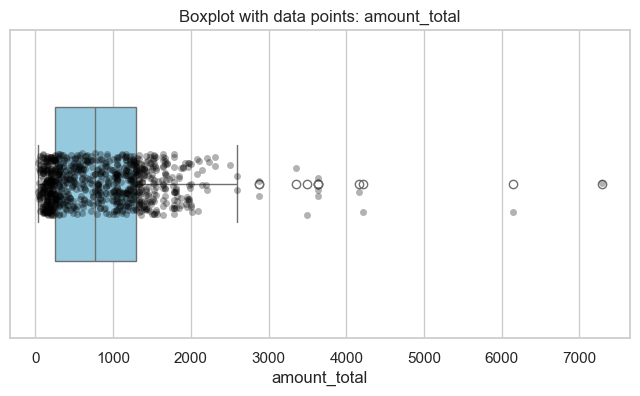

In [77]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=data3["amount_total"], width=0.5, color='skyblue')
sns.stripplot(x=data3["amount_total"], color='black', alpha=0.3, jitter=True)  # 显示点
plt.title("Boxplot with data points: amount_total")
plt.xlabel("amount_total")
plt.show()

In [78]:
Q1 = data3["amount_total"].quantile(0.25)
Q3 = data3["amount_total"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 条件筛选出极端值
outliers_1 = data3[data3["amount_total"] < lower_bound]
outliers_2 = data3[data3["amount_total"] > upper_bound]

# 打印数量
print("极端值数量:", len(outliers_1), len(outliers_2))
print("总样本数量:", len(data3))



极端值数量: 0 11
总样本数量: 884


In [79]:
data3 = data3[(data3["amount_total"] >= lower_bound) & (data3["amount_total"] <= upper_bound)]

#### 1-9 output data

In [80]:
data3.to_csv("Cleaned_Data_0509.csv", index=False)

### 2 description analysis

In [81]:
# read data
data_a = pd.read_csv("Cleaned_Data_0509.csv", encoding='latin1')


In [82]:
data_a

,care_team,age,occupation,intake_no_of_hh,income_assessment_salary,income_assessment_cpf_payout,income_assessment_assistance_from_other_agencies,income_assessment_assistance_from_relatives_friends,income_assessment_insurance_payout,income_assessment_rental_income,...,tertiary_18_21,adult_22_64,elderly_65_and_above,no_of_hh_cal,diff_hh,income_total_cal,expenditure_total_cal,difference_cal,amount_total,points
0,central 1 1,13.0,student,3.0,0.0,0.00,500.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,500.00,1601.9,-1101.90,900.00,0
1,central 1 1,57.0,unemployed,2.0,1500.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1500.00,1084.0,416.00,1144.90,0
2,central 1 1,32.0,unemployed,4.0,3380.0,0.00,0.0,500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3880.00,3494.0,386.00,243.00,0
3,central 1 1,69.0,NaN,2.0,525.0,0.00,200.0,400.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1125.00,1114.0,11.00,243.00,0
4,central 1 1,70.0,NaN,1.0,134.0,0.00,90.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,474.00,700.0,-226.00,200.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,south 1 1,55.0,unemployed,4.0,0.0,0.00,1780.0,0.0,0.0,0.0,...,1.0,2.0,0.0,3.0,0.0,1780.00,1730.0,50.00,717.20,1
869,east 1 1,55.0,employed,1.0,0.0,0.00,600.0,150.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,750.00,2285.0,-1535.00,396.80,2
870,south 2 2,62.0,unemployed,3.0,0.0,0.00,1080.0,0.0,0.0,500.0,...,0.0,0.0,0.0,0.0,0.0,1580.00,1530.0,50.00,126.00,0
871,east 2 2,66.0,employed,0.0,2800.0,876.95,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,4.0,0.0,3676.95,2416.5,1260.45,1213.15,2


In [83]:
data_a.columns

Index(['care_team', 'age', 'occupation', 'intake_no_of_hh',
       'income_assessment_salary', 'income_assessment_cpf_payout',
       'income_assessment_assistance_from_other_agencies',
       'income_assessment_assistance_from_relatives_friends',
       'income_assessment_insurance_payout', 'income_assessment_rental_income',
       'income_assessment_others_income',
       'expenditure_assessment_mortgage_rental',
       'expenditure_assessment_utilities', 'expenditure_assessment_s_cc_fees',
       'expenditure_assessment_food_expenses',
       'expenditure_assessment_marketing_groceries',
       'expenditure_assessment_telecommunications',
       'expenditure_assessment_transportation',
       'expenditure_assessment_medical_expenses',
       'expenditure_assessment_education_expense',
       'expenditure_assessment_contribution_to_family_members',
       'expenditure_assessment_domestic_helper',
       'expenditure_assessment_loans_debts_installments',
       'expenditure_assessment

#### 2-1 family info

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

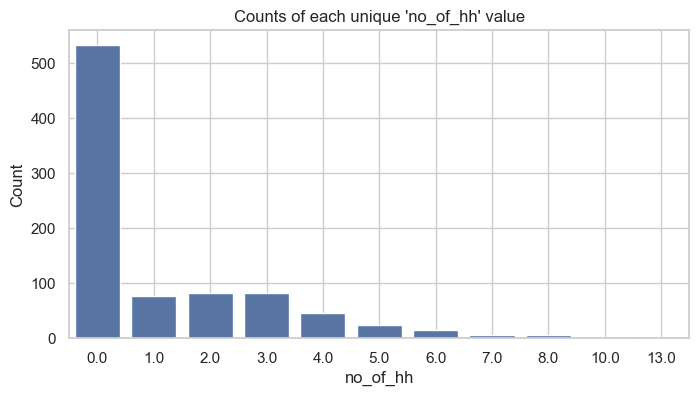

In [85]:
# 'no_of_hh', 'intake_no_of_hh', 'no_of_hh', 'before_primary', 'primary_7_12', 'secondary_13_17', 'tertiary_18_21', 'adult_22_64', 'elderly_65_and_above' 
value_counts = data_a["no_of_hh"].value_counts().sort_index()

plt.figure(figsize=(8, 4))
sns.barplot(x=value_counts.index, y=value_counts.values)

plt.title("Counts of each unique 'no_of_hh' value")
plt.xlabel("no_of_hh")
plt.ylabel("Count")
plt.grid(True)
plt.show()


🧪 Analyzing column: income_assessment_salary

count     873.000000
mean     1076.189874
std      1454.366889
min         0.000000
25%         0.000000
50%       138.000000
75%      1800.000000
max      8440.680000
Name: income_assessment_salary, dtype: float64


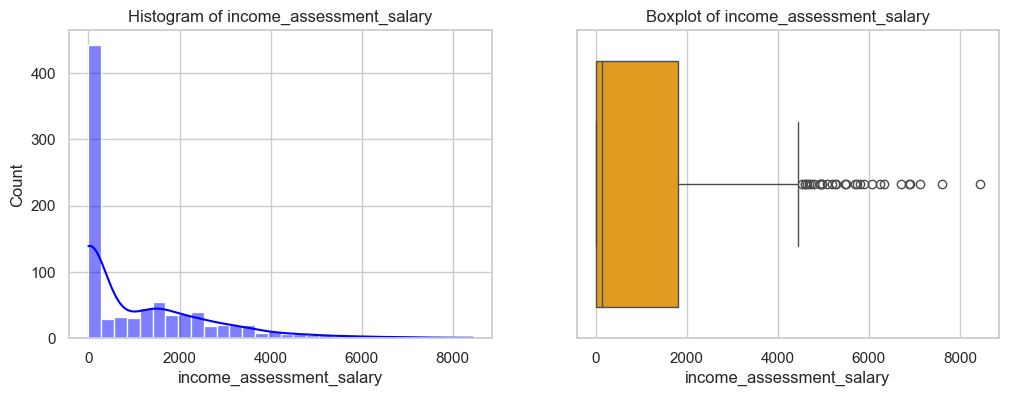


🧪 Analyzing column: income_assessment_cpf_payout

count     873.000000
mean      147.009794
std       321.448945
min         0.000000
25%         0.000000
50%         0.000000
75%       180.000000
max      5000.000000
Name: income_assessment_cpf_payout, dtype: float64


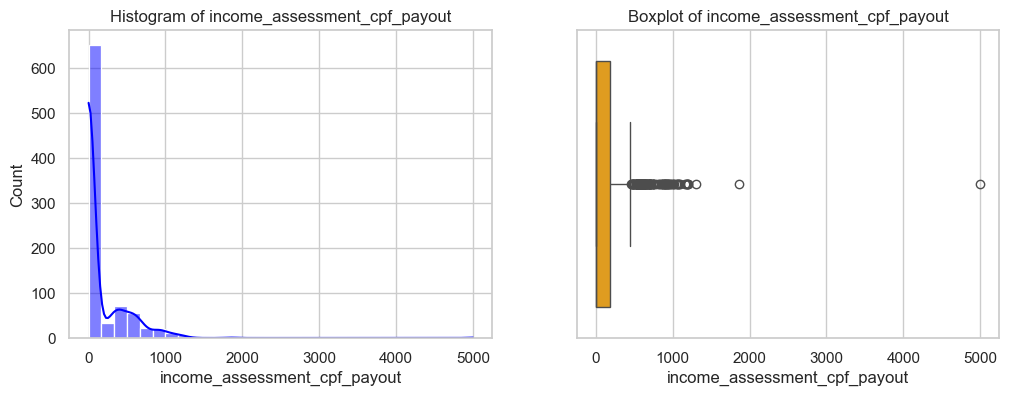


🧪 Analyzing column: income_assessment_assistance_from_other_agencies

count     873.000000
mean      307.575155
std       411.911270
min         0.000000
25%         0.000000
50%       180.000000
75%       500.000000
max      2276.000000
Name: income_assessment_assistance_from_other_agencies, dtype: float64


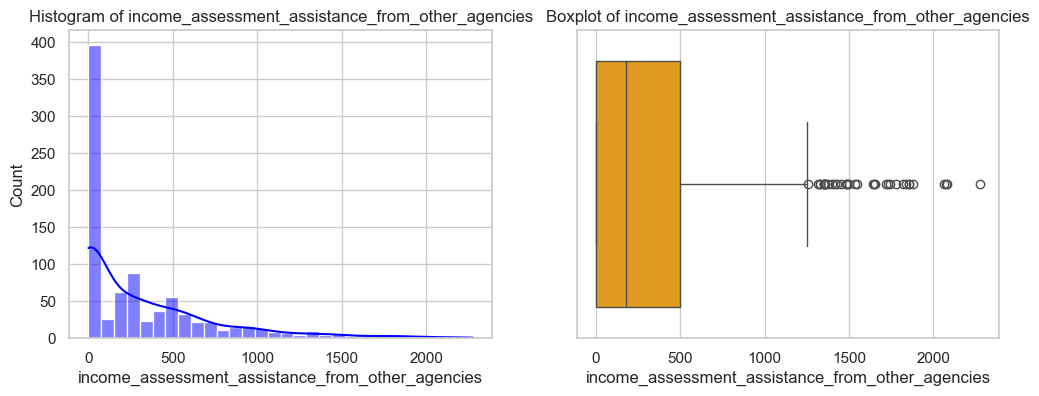


🧪 Analyzing column: income_assessment_assistance_from_relatives_friends

count     873.000000
mean      101.150630
std       266.477555
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2976.000000
Name: income_assessment_assistance_from_relatives_friends, dtype: float64


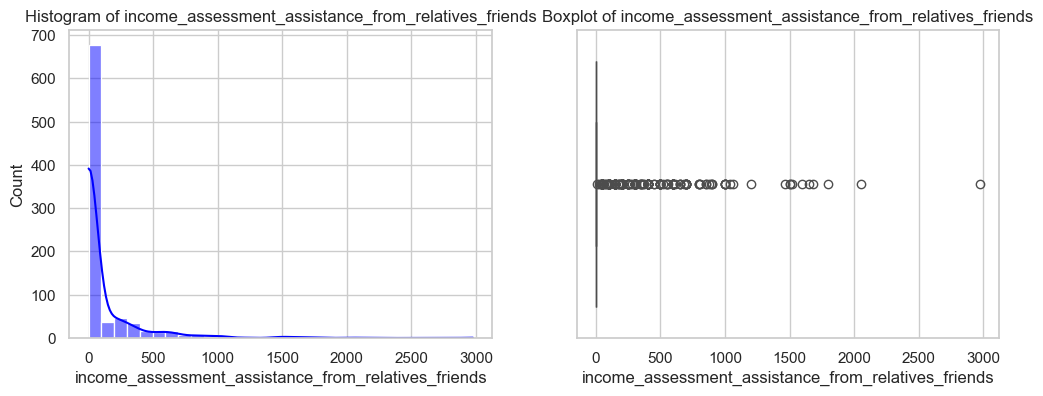


🧪 Analyzing column: income_assessment_insurance_payout

count    873.000000
mean       1.320813
std       26.594881
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      726.000000
Name: income_assessment_insurance_payout, dtype: float64


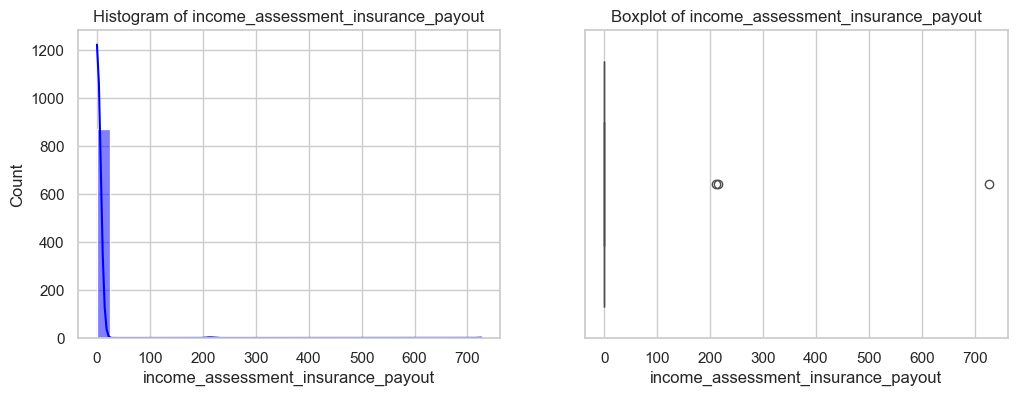


🧪 Analyzing column: income_assessment_rental_income

count     873.000000
mean       58.801833
std       266.176755
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2600.000000
Name: income_assessment_rental_income, dtype: float64


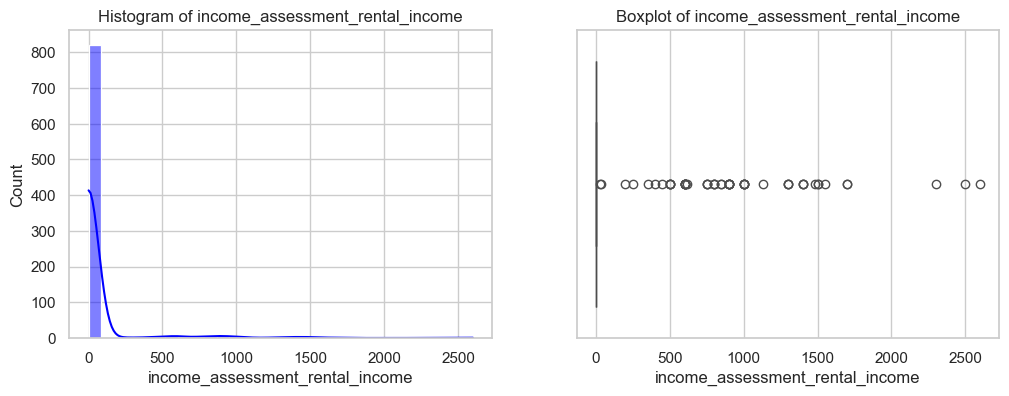


🧪 Analyzing column: income_assessment_others_income

count     873.000000
mean       22.257617
std       174.556144
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3700.000000
Name: income_assessment_others_income, dtype: float64


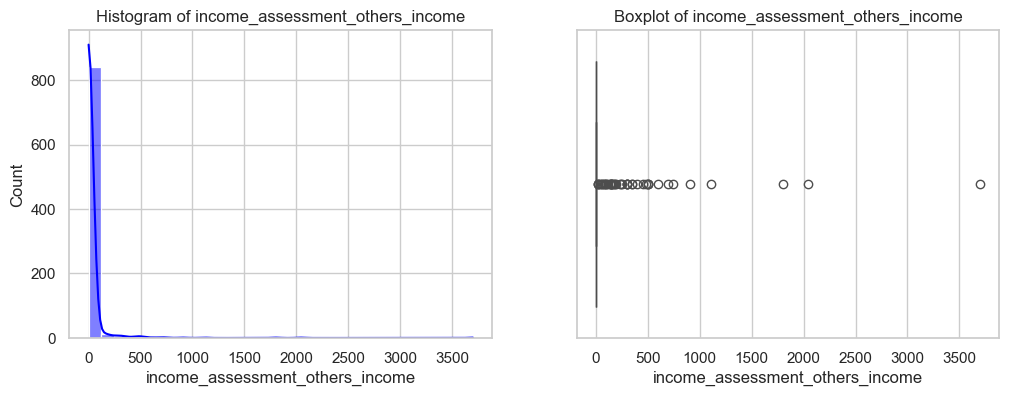


🧪 Analyzing column: expenditure_assessment_mortgage_rental

count     873.000000
mean       85.708751
std       310.046493
min         0.000000
25%         0.000000
50%         0.000000
75%        44.000000
max      3800.000000
Name: expenditure_assessment_mortgage_rental, dtype: float64


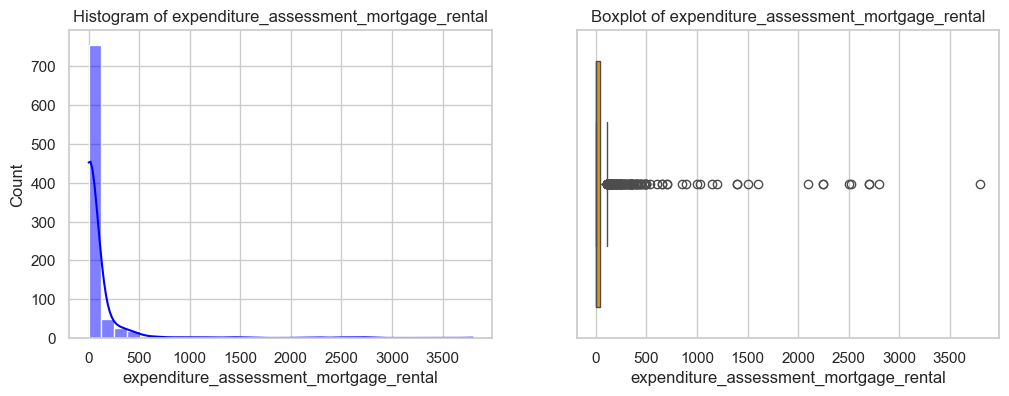


🧪 Analyzing column: expenditure_assessment_utilities

count    873.000000
mean     133.039439
std      113.646598
min        0.000000
25%       40.000000
50%      120.000000
75%      200.000000
max      665.000000
Name: expenditure_assessment_utilities, dtype: float64


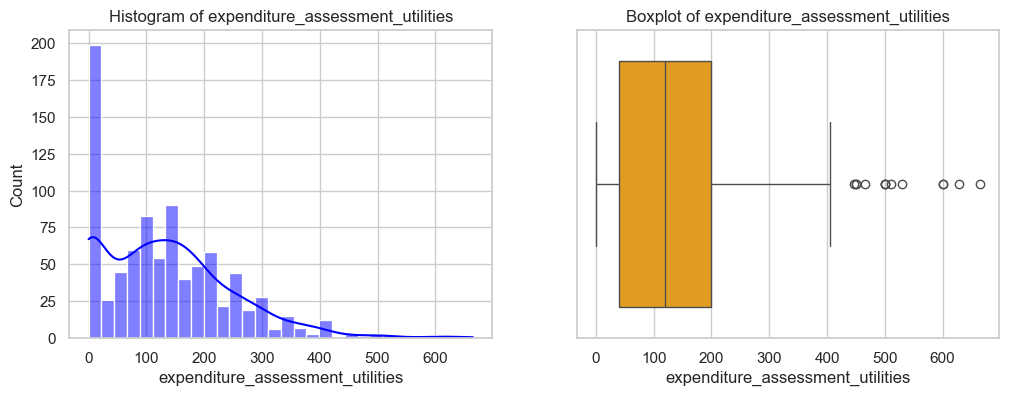


🧪 Analyzing column: expenditure_assessment_s_cc_fees

count    873.000000
mean      38.924479
std       30.871960
min        0.000000
25%        0.000000
50%       44.500000
75%       63.000000
max      300.000000
Name: expenditure_assessment_s_cc_fees, dtype: float64


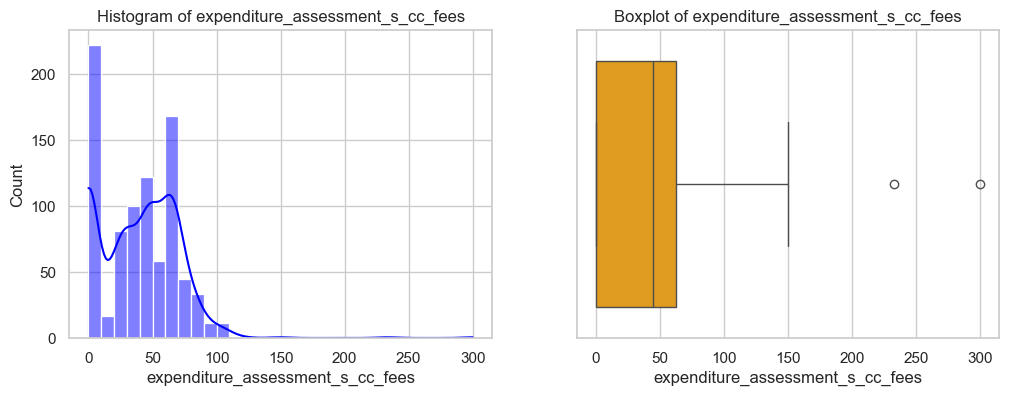


🧪 Analyzing column: expenditure_assessment_food_expenses

count      873.000000
mean       592.845315
std        520.633042
min          0.000000
25%        300.000000
50%        500.000000
75%        800.000000
max      10000.000000
Name: expenditure_assessment_food_expenses, dtype: float64


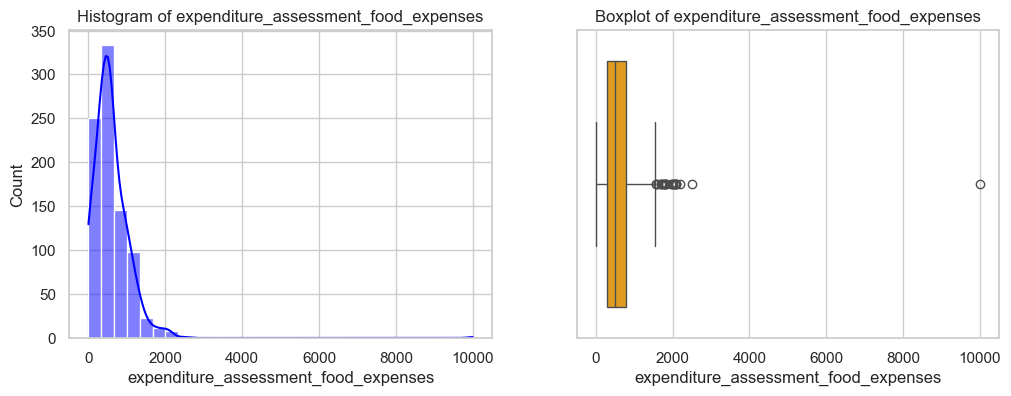


🧪 Analyzing column: expenditure_assessment_marketing_groceries

count     873.000000
mean       65.673081
std       169.065288
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1309.500000
Name: expenditure_assessment_marketing_groceries, dtype: float64


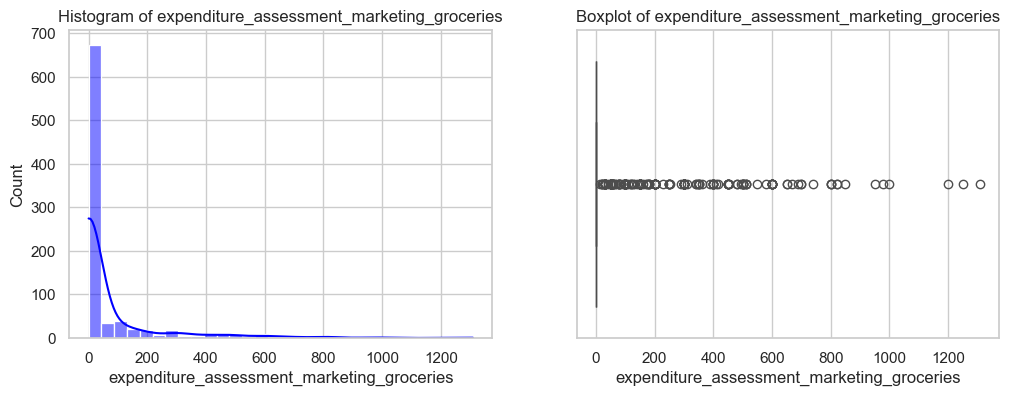


🧪 Analyzing column: expenditure_assessment_telecommunications

count    873.000000
mean     104.382509
std      107.510827
min        0.000000
25%       26.000000
50%       77.000000
75%      150.000000
max      776.000000
Name: expenditure_assessment_telecommunications, dtype: float64


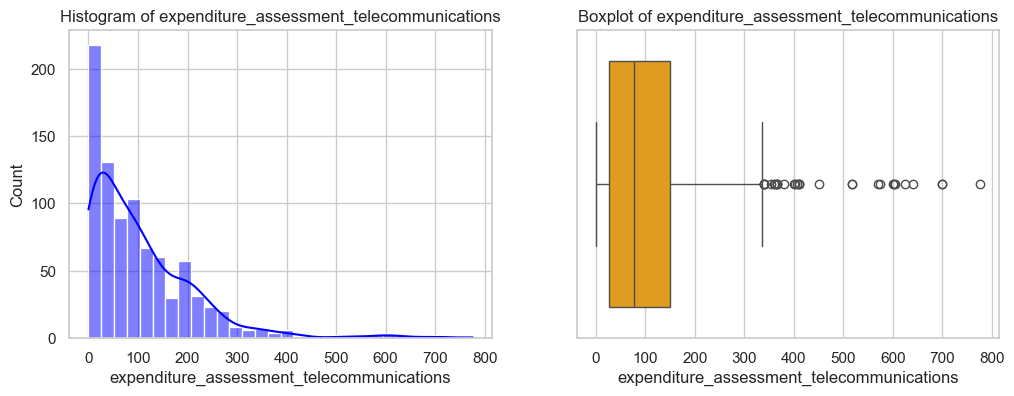


🧪 Analyzing column: expenditure_assessment_transportation

count     873.000000
mean      185.666312
std       318.633906
min         0.000000
25%        40.000000
50%       100.000000
75%       220.000000
max      4318.000000
Name: expenditure_assessment_transportation, dtype: float64


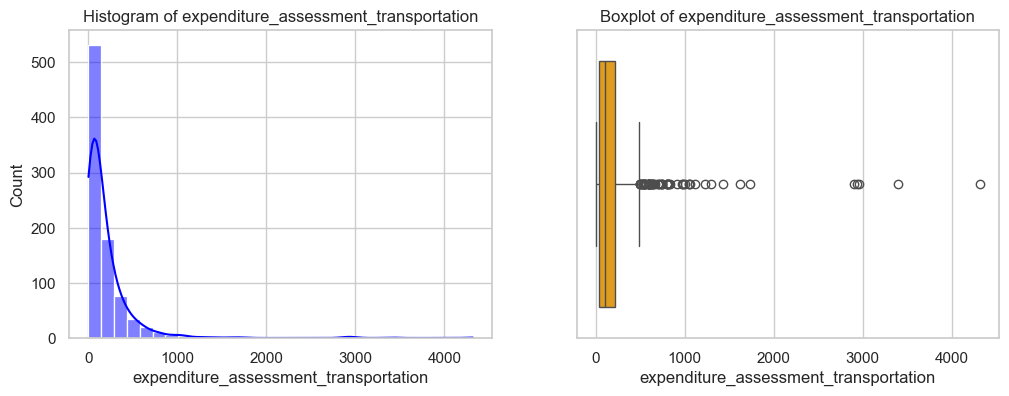


🧪 Analyzing column: expenditure_assessment_medical_expenses

count     873.000000
mean      127.419416
std       281.695010
min         0.000000
25%         0.000000
50%         0.000000
75%       150.000000
max      3145.930000
Name: expenditure_assessment_medical_expenses, dtype: float64


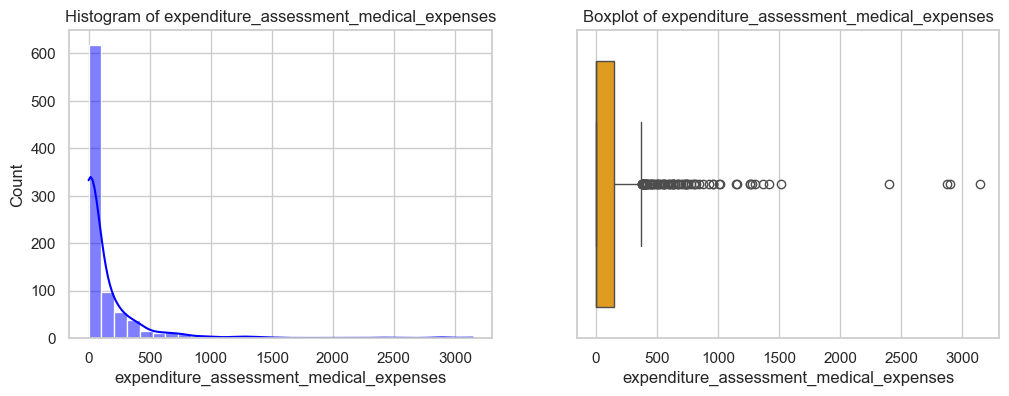


🧪 Analyzing column: expenditure_assessment_education_expense

count     873.000000
mean       70.565189
std       219.819581
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1930.000000
Name: expenditure_assessment_education_expense, dtype: float64


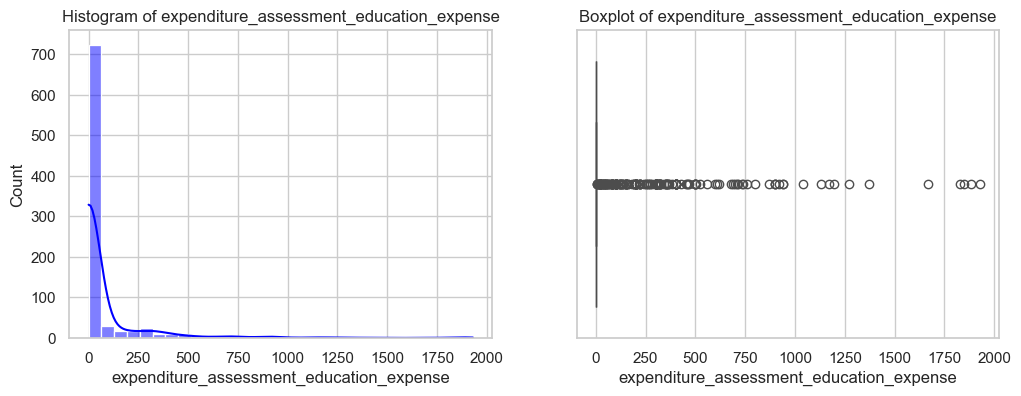


🧪 Analyzing column: expenditure_assessment_contribution_to_family_members

count     873.000000
mean       13.940435
std       102.645315
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1500.000000
Name: expenditure_assessment_contribution_to_family_members, dtype: float64


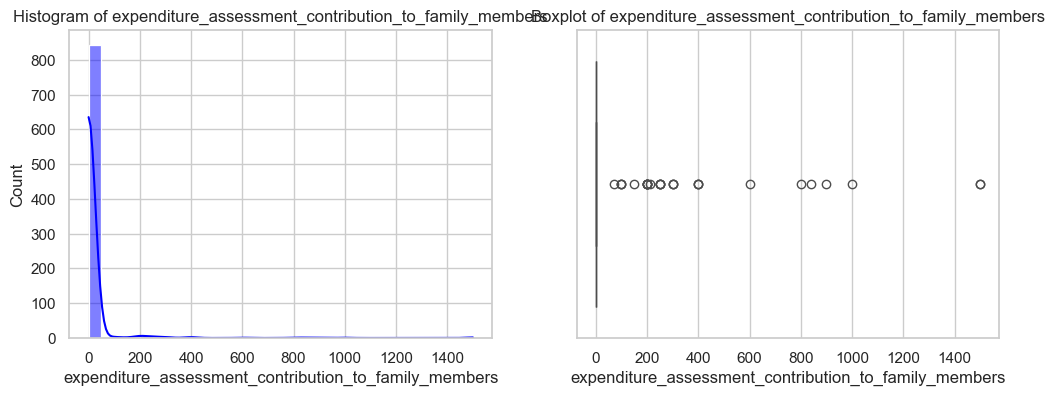


🧪 Analyzing column: expenditure_assessment_domestic_helper

count     873.000000
mean       77.028637
std       228.428372
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1720.000000
Name: expenditure_assessment_domestic_helper, dtype: float64


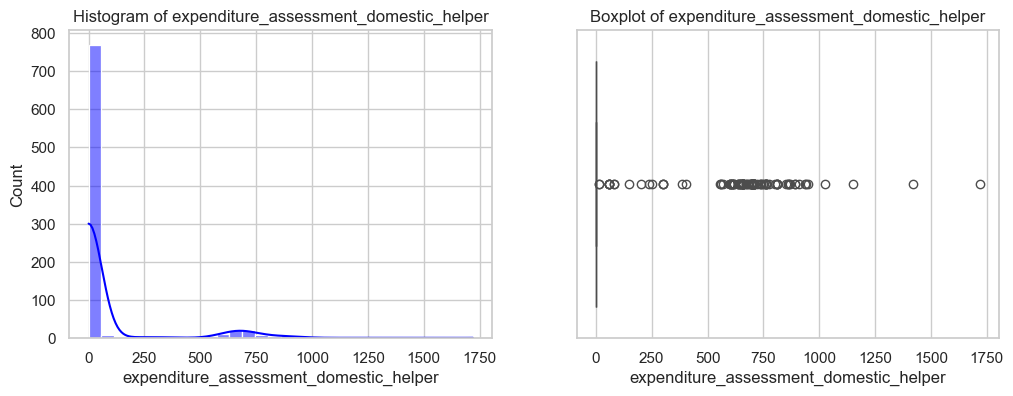


🧪 Analyzing column: expenditure_assessment_loans_debts_installments

count     873.000000
mean       31.216896
std       218.784619
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6000.000000
Name: expenditure_assessment_loans_debts_installments, dtype: float64


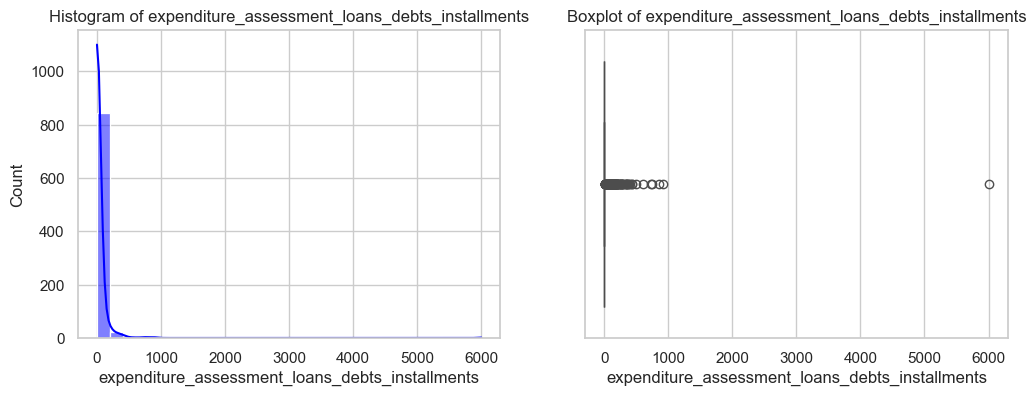


🧪 Analyzing column: expenditure_assessment_insurance_premiums

count    873.000000
mean       8.687239
std       35.955964
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      445.000000
Name: expenditure_assessment_insurance_premiums, dtype: float64


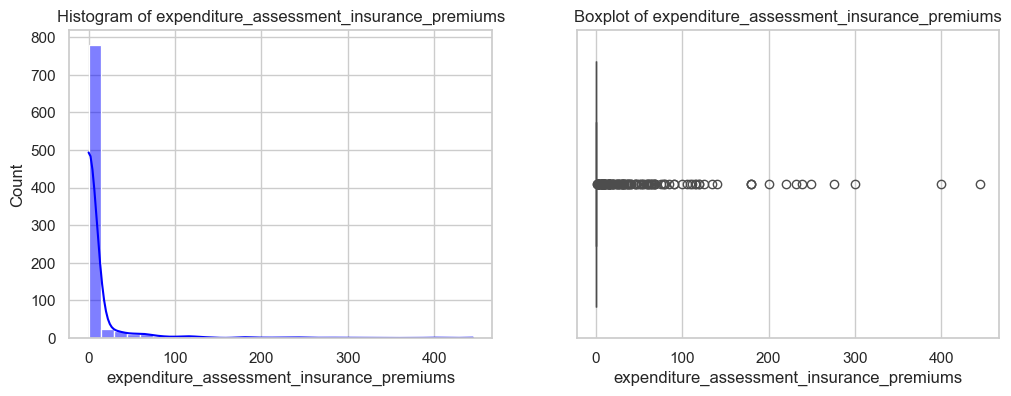


🧪 Analyzing column: expenditure_assessment_others_expenditure

count     873.000000
mean      183.823150
std       391.209882
min         0.000000
25%         0.000000
50%         0.000000
75%       200.000000
max      3300.000000
Name: expenditure_assessment_others_expenditure, dtype: float64


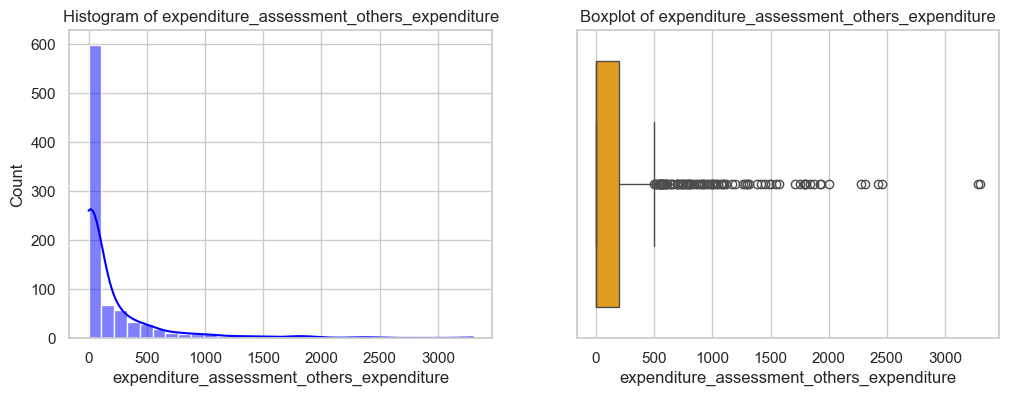


🧪 Analyzing column: income_total_cal

count     873.000000
mean     1714.305716
std      1407.305515
min         0.000000
25%       680.000000
50%      1400.000000
75%      2350.000000
max      8740.680000
Name: income_total_cal, dtype: float64


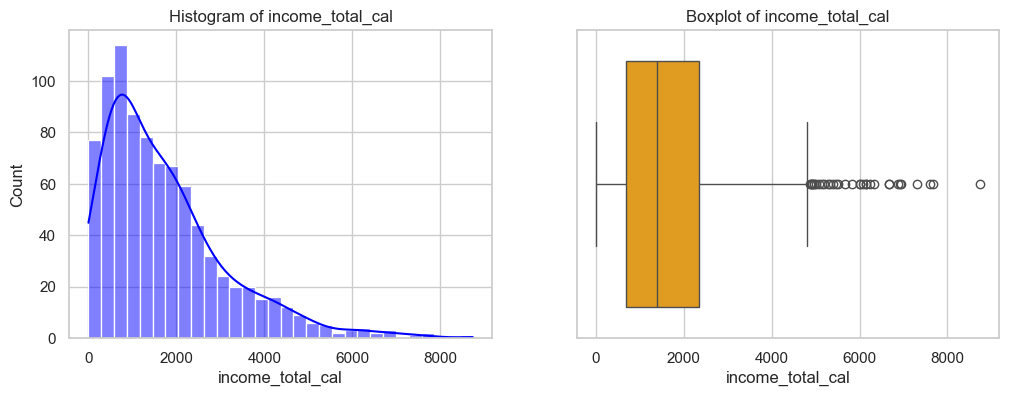


🧪 Analyzing column: expenditure_total_cal

count      873.000000
mean      1718.920848
std       1322.209507
min          0.000000
25%        823.100000
50%       1416.500000
75%       2258.000000
max      12439.300000
Name: expenditure_total_cal, dtype: float64


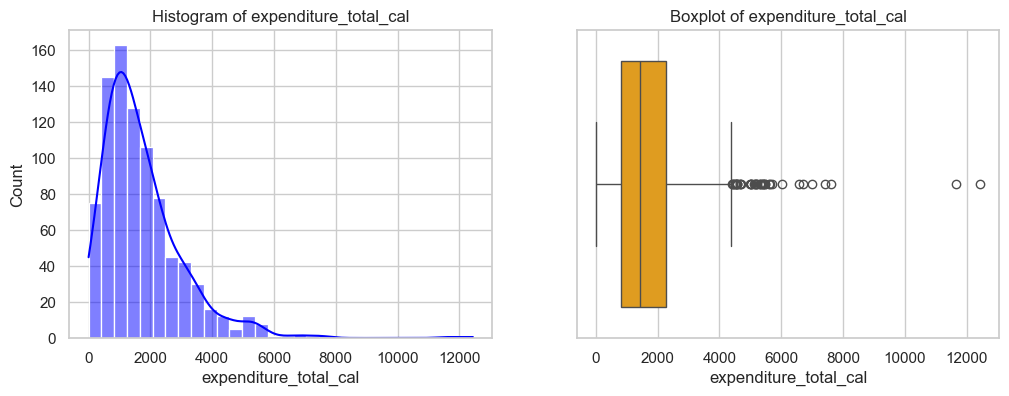


🧪 Analyzing column: difference_cal

count     873.000000
mean       -4.615132
std       884.566585
min     -9899.300000
25%      -283.230000
50%         0.000000
75%       295.000000
max      4231.350000
Name: difference_cal, dtype: float64


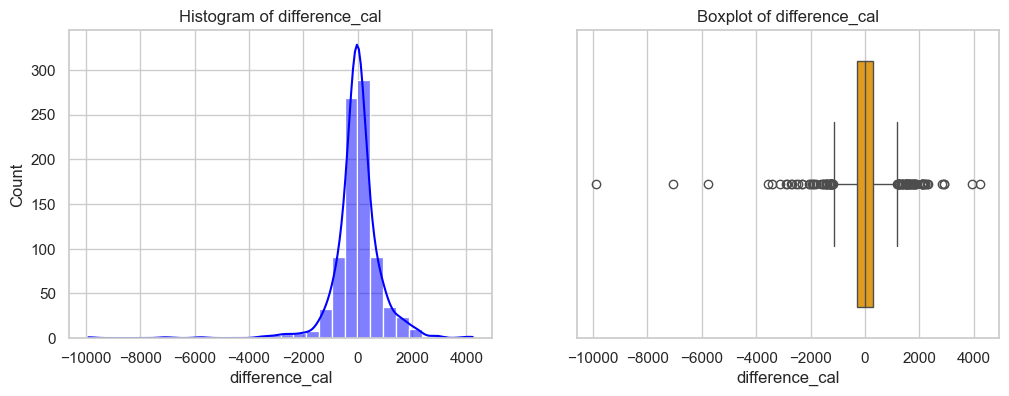


🧪 Analyzing column: current_savings

count      873.000000
mean      1088.317102
std       3302.616509
min        -14.400000
25%          0.000000
50%          0.000000
75%        500.000000
max      45000.000000
Name: current_savings, dtype: float64


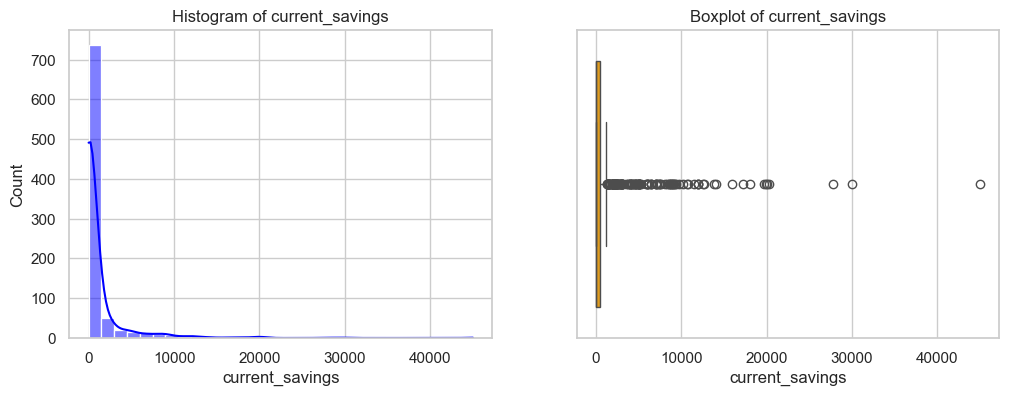

In [86]:
# 设置显示风格
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

# 要分析的列
columns_to_explore = [
    'income_assessment_salary',
    'income_assessment_cpf_payout',
    'income_assessment_assistance_from_other_agencies',
    'income_assessment_assistance_from_relatives_friends',
    'income_assessment_insurance_payout',
    'income_assessment_rental_income',
    'income_assessment_others_income',
    'expenditure_assessment_mortgage_rental',
    'expenditure_assessment_utilities',
    'expenditure_assessment_s_cc_fees',
    'expenditure_assessment_food_expenses',
    'expenditure_assessment_marketing_groceries',
    'expenditure_assessment_telecommunications',
    'expenditure_assessment_transportation',
    'expenditure_assessment_medical_expenses',
    'expenditure_assessment_education_expense',
    'expenditure_assessment_contribution_to_family_members',
    'expenditure_assessment_domestic_helper',
    'expenditure_assessment_loans_debts_installments',
    'expenditure_assessment_insurance_premiums',
    'expenditure_assessment_others_expenditure',
    'income_total_cal',
    'expenditure_total_cal',
    'difference_cal',
    'current_savings'
]

# 遍历每个列做分析
for col in columns_to_explore:
    print(f"\n{'='*60}\n🧪 Analyzing column: {col}\n")

    # 描述统计信息
    print(data_a[col].describe())

    # 直方图
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data_a[col], kde=True, bins=30, color='blue')
    plt.title(f"Histogram of {col}")

    # 箱线图
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_a[col], color='orange')
    plt.title(f"Boxplot of {col}")
    plt.show()
